# 4. Desafio da sprint 02
Este notebook realiza a leitura de um arquivo CSV que contém dados de aplicativos da Google Play Store.   
O objetivo é processar os dados atendendo cada etapa do desafio, onde teremos processamento de dados com funções e respostas, e também gráficos analíticos plotados diretamente no notebook. 


## 4.1 - Ambiente: Importação de bibliotecas - Panda e Matplotlib
Para iniciar faremos a importação das bibliotecas abaixo, com as respectivas funcionalidades:  
**Pandas**: facilita o trabalho com tabelas, otimizando linhas de código. Como exemplo, praticamente não se verá funções lambda com a utilização dos recursos de Pandas.  
**Matplotlib**: biblioteca que nos permitirá gerar/ plotar gráficos (de barras verticais ou horizontais, dispersões, pizza, etc).  
**Numpy**: biblioteca que otimizará o tratamento de formatos numéricos aqui no nosso caso.

In [35]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 4.2 - Desenvolvimento: as atividades propostas pelo desafio

### 1. Criando o dataframe com Pandas
Nessa etapa, através dos recursos da biblioteca Pandas, realizaremos a extração do conteúdo do csv e realizaremos a remoção de duplicatas

#### Detector de linhas inconsistentes no dataset (parte de antecipação ao ETL)  
*Obs: as linhas 4453 e 4490 apareceriam ao rodar o script, mas listei como exceção após análise visual da linha*

In [36]:
# Função para verificar inconsistências na última coluna e imprimir possíveis linhas problemáticas
def verificar_ultima_coluna_vazia(df):
    num_colunas = df.shape[1]  # Número total de colunas
    inconsistencias = []

    # Verificar a última coluna para identificar linhas vazias
    for idx in df.index:
        if pd.isna(df.iloc[idx, num_colunas - 1]):  # Verifica se o último elemento da linha é NaN
            if idx not in [4453, 4490]:  # Ignorar as linhas 4453 e 4490 que observei a olho nu que estão ok, apesar de NaN
                inconsistencias.append(idx)
                print(f"Possível inconsistência encontrada na linha {idx} (coluna 13 está vazia).")

    if inconsistencias:
        print(f"{len(inconsistencias)} possível(eis) inconsistência(s) encontrada(s). Verifique as linhas listadas.")
    else:
        print("Nenhuma inconsistência encontrada na última coluna.")

    return inconsistencias

# Ler o arquivo CSV
data = pd.read_csv('googleplaystore.csv')

# Executar a verificação da última coluna
verificar_ultima_coluna_vazia(data)


Possível inconsistência encontrada na linha 10472 (coluna 13 está vazia).
1 possível(eis) inconsistência(s) encontrada(s). Verifique as linhas listadas.


[10472]

#### Tratamento da linha 10472

In [37]:
# Tratamento da linha 10472 para corrigir a inconsistência
import pandas as pd

# Ler o arquivo CSV
data = pd.read_csv('googleplaystore.csv')

# Função para corrigir a linha 10472
def corrigir_linha_10472(df):
    idx = 10472  # Índice da linha a ser corrigida
    if idx in df.index:
        print(f"Linha antes da correção:\n{df.loc[idx]}\n")
        
        # Manter o conteúdo da primeira coluna e preencher a segunda com 'NaN'
        df.loc[idx, df.columns[1:]] = df.loc[idx, df.columns[:-1]].astype(str).shift(1)
        df.loc[idx, 'Category'] = 'NaN'
        
        print(f"Linha após a correção:\n{df.loc[idx]}\n")
    else:
        print("Linha 10472 não encontrada no DataFrame.")
    
    return df

# Aplicar a correção na linha 10472
data = corrigir_linha_10472(data)

# Bloco de código para testar o DataFrame e confirmar que a linha 10472 foi tratada
def testar_dataframe_corrigido(df):
    # Verifica se a linha 10472 tem 13 elementos, incluindo NaNs, e imprime um resumo
    linha_10472 = df.loc[10472]
    num_elementos = len(linha_10472)  # Conta todos os elementos, incluindo NaNs
    print(f"Contagem de elementos na linha 10472 após correção: {num_elementos}")
    if num_elementos == df.shape[1]:
        print("Linha 10472 foi tratada corretamente e não é mais inconsistente.")
    else:
        print("Linha 10472 ainda apresenta inconsistências.")

# Testar o DataFrame
testar_dataframe_corrigido(data)


Linha antes da correção:
App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

Linha após a correção:
App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              NaN
Rating                                                

/tmp/ipykernel_38193/2277772425.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, df.columns[1:]] = df.loc[idx, df.columns[:-1]].astype(str).shift(1)


#### Tratamento 'padrão' ETL

In [38]:
# Bloco de código para tratamentos adicionais no DataFrame

# Remover duplicidades
data = data.drop_duplicates()

# Tratar a coluna 'Price': converter para string, remover o símbolo '$' e converter para float
data['Price'] = data['Price'].astype(str).str.replace('$', '', regex=False).astype(float)

# Converter a coluna 'Reviews' para float e depois para int, tratando erros
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce').fillna(0).astype(int)

# Exibir mensagem de sucesso
def verificar_tratamentos(df):
    print("Tratamentos realizados com sucesso:")
    print(f"Total de linhas após remoção de duplicidades: {df.shape[0]}")
    print(f"Tipo de dados da coluna 'Price': {df['Price'].dtype}")
    print(f"Tipo de dados da coluna 'Reviews': {df['Reviews'].dtype}")

# Verificar o DataFrame após os tratamentos
verificar_tratamentos(data)



Tratamentos realizados com sucesso:
Total de linhas após remoção de duplicidades: 10358
Tipo de dados da coluna 'Price': float64
Tipo de dados da coluna 'Reviews': int64


### 2. Faça um gráfico de barras contendo os top 5 apps por número de instalação  
Um comentário que é válido para este desafio é que, ao final do filtro que seleciona os apps na 'categoria' `1,000,000,000+ instalações` temos 20 apps, e o top 5 plotado no gráfico obedece a ordem de aparição/ ordenação das linhas do dataset, como uma "funcionalidade" nativa da biblioteca.

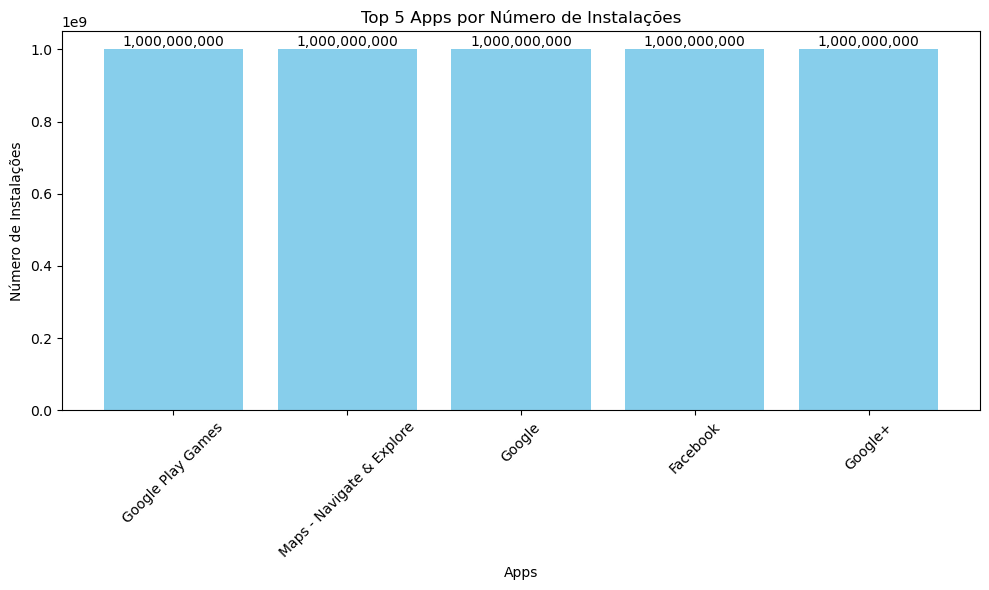

In [39]:
import matplotlib.pyplot as plt

# Converter a coluna 'Installs' para string e remover caracteres indesejados apenas se necessário
data['Installs'] = data['Installs'].astype(str).str.replace(',', '').str.replace('+', '').astype(int)

# Selecionar os top 5 apps por número de instalações
top_5_apps = data.sort_values(by='Installs', ascending=False).head(5)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(top_5_apps['App'], top_5_apps['Installs'], color='skyblue')
plt.title('Top 5 Apps por Número de Instalações')
plt.xlabel('Apps')
plt.ylabel('Número de Instalações')
plt.xticks(rotation=45)

# Adicionar os números de instalações em cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,}', va='bottom', ha='center')

plt.tight_layout()
plt.show()


### 3. Faça um gráfico de pizza (pie chart) mostrando as categorias de apps existentes no dataset de acordo com a frequência em que elas aparecem.

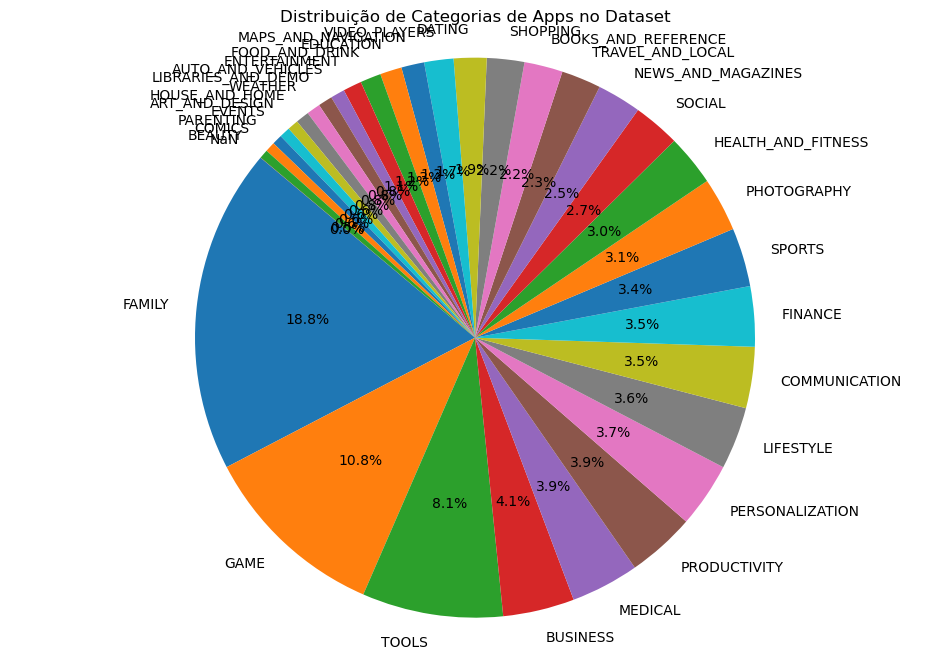

In [40]:
import matplotlib.pyplot as plt

# Contar a frequência das categorias no dataset
categoria_frequencia = data['Category'].value_counts()

# Criar um gráfico de pizza
plt.figure(figsize=(12, 8))
plt.pie(categoria_frequencia, labels=categoria_frequencia.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição de Categorias de Apps no Dataset')
plt.axis('equal')  # Para garantir que o gráfico seja um círculo perfeito
plt.show()


### 4. Mostre qual o app mais caro existente no dataset.  


In [41]:
# Encontrar o app mais caro no dataset
app_mais_caro = data.loc[data['Price'].idxmax()]

# Exibir o resultado
print(f"App mais caro do dataset: {app_mais_caro['App']} - ${app_mais_caro['Price']}")



App mais caro do dataset: I'm Rich - Trump Edition - $400.0


### 5. Mostre quantos apps são classificados como 'Mature 17+'.  
*Obs: importante destacar que sem o tratamento adequado, o primeiro resultado obtido tinha sido 447, mas havia uma contagem com duplicidades. Por isso foi aplicado um `drop_duplicates` com o subset na coluna "App" para uma contagem única de itens.*


In [42]:
# Contar quantos apps são classificados como 'Mature 17+'
data_unique = data.drop_duplicates(subset=['App'])
num_mature_apps = data_unique[data_unique['Content Rating'] == 'Mature 17+'].shape[0]

# Exibir o resultado
print(f"Número de apps classificados como 'Mature 17+': {num_mature_apps}")

Número de apps classificados como 'Mature 17+': 393


### 6. Mostre o top 10 apps por número de reviews bem como o respectivo número de reviews. Ordene a lista de forma decrescente por número de reviews.  


In [43]:
# Mostrar o top 10 apps por número de reviews
# Remover duplicatas com base na coluna 'App'
data_unique = data.drop_duplicates(subset=['App'])

# Ordenar o dataset por número de reviews de forma decrescente
top_10_reviews = data_unique.sort_values(by='Reviews', ascending=False).head(10)

# Exibir o resultado
print("Top 10 apps por número de reviews:")
for index, row in top_10_reviews.iterrows():
    print(f"{row['App']} - {row['Reviews']} reviews")

Top 10 apps por número de reviews:
Facebook - 78158306 reviews
WhatsApp Messenger - 69119316 reviews
Instagram - 66577313 reviews
Messenger – Text and Video Chat for Free - 56642847 reviews
Clash of Clans - 44891723 reviews
Clean Master- Space Cleaner & Antivirus - 42916526 reviews
Subway Surfers - 27722264 reviews
YouTube - 25655305 reviews
Security Master - Antivirus, VPN, AppLock, Booster - 24900999 reviews
Clash Royale - 23133508 reviews


### 7. Crie pelo menos mais 2 cálculos sobre o dataset e apresente um em formato de lista e outro em formato de valor. Por exemplo: "top 10 apps por número de reviews" e "o app mais caro existente no dataset."  

In [44]:
# Mostrar o top 10 apps por número de versões lançadas
# Contar o número de versões por app
# Utilizar o dataset original 'data' para essa análise
top_10_versions = data['App'].value_counts().head(10)

# Exibir o resultado
print("Top 10 apps por número de versões lançadas:")
for app, count in top_10_versions.items():
    print(f"{app} - {count} versões")

# Cálculo adicional 1: Top 10 categorias por número de apps (após remover duplicatas na coluna 'App')
data_unique = data.drop_duplicates(subset=['App'])
print("\nTop 10 categorias por número de apps:")
top_10_categorias = data_unique['Category'].value_counts().head(10)
for categoria, count in top_10_categorias.items():
    print(f"{categoria} - {count} apps")


Top 10 apps por número de versões lançadas:
ROBLOX - 9 versões
8 Ball Pool - 7 versões
Bubble Shooter - 6 versões
Helix Jump - 6 versões
Zombie Catchers - 6 versões
slither.io - 5 versões
Angry Birds Classic - 5 versões
Farm Heroes Saga - 5 versões
Candy Crush Saga - 5 versões
Subway Surfers - 5 versões

Top 10 categorias por número de apps:
FAMILY - 1832 apps
GAME - 959 apps
TOOLS - 827 apps
BUSINESS - 420 apps
MEDICAL - 395 apps
PERSONALIZATION - 376 apps
PRODUCTIVITY - 374 apps
LIFESTYLE - 369 apps
FINANCE - 345 apps
SPORTS - 325 apps


### 8. Crie pelo menos outras 2 formas gráficas de exibição dos indicadores acima utilizando a biblioteca matplotlib. Escolha tipos de gráficos diferentes dos explorados acima. Por exemplo: linhas e dispersão.  

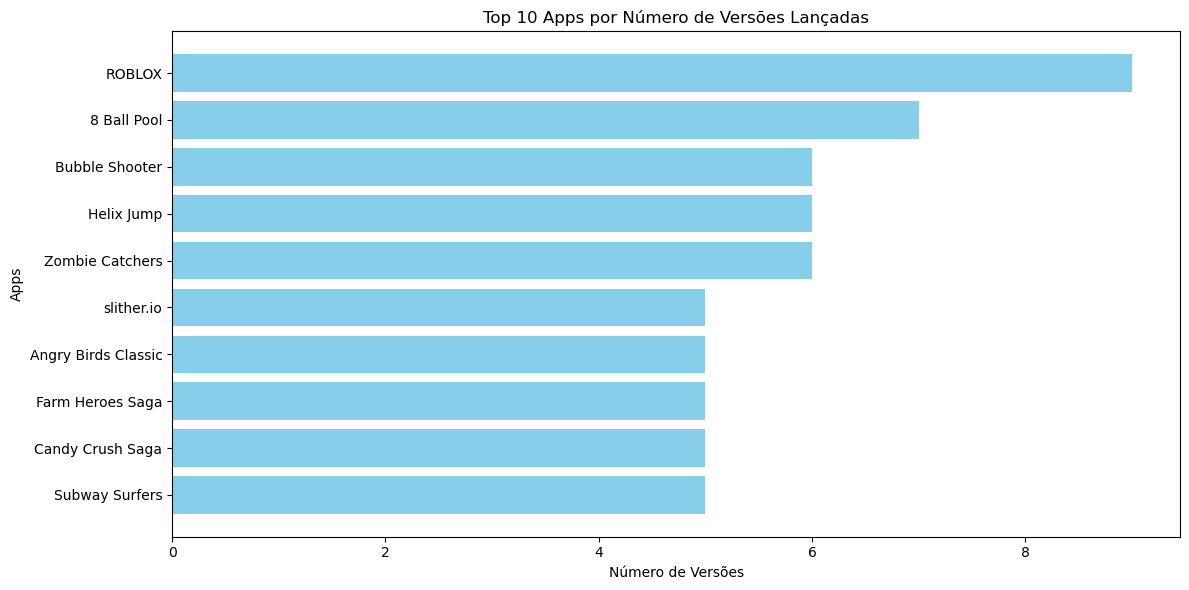

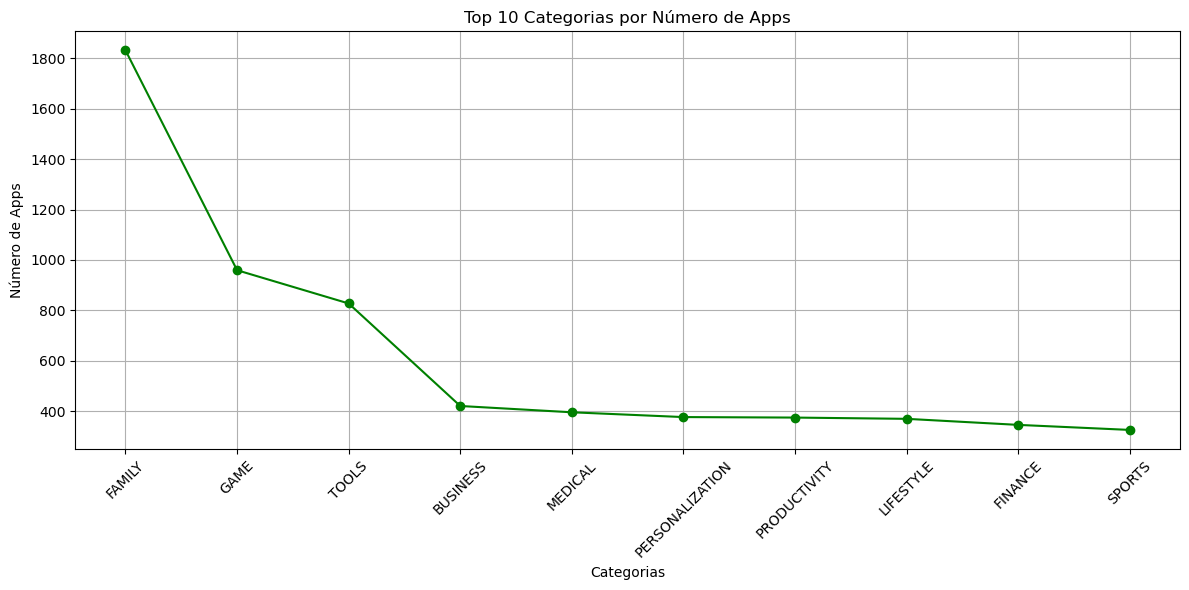

In [45]:
import matplotlib.pyplot as plt

# Contagem de versões de todos os apps
versoes_por_app = data['App'].value_counts()

# Gráfico de barras horizontais para o top 10 apps por número de versões
plt.figure(figsize=(12, 6))
versoes_top_10 = versoes_por_app.head(10)
plt.barh(versoes_top_10.index, versoes_top_10.values, color='skyblue')
plt.title('Top 10 Apps por Número de Versões Lançadas')
plt.xlabel('Número de Versões')
plt.ylabel('Apps')
plt.gca().invert_yaxis()  # Inverter a ordem para mostrar o maior no topo
plt.tight_layout()
plt.show()

# Gráfico de linhas para as 10 principais categorias por número de apps
data_unique = data.drop_duplicates(subset=['App'])
top_10_categorias = data_unique['Category'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.plot(top_10_categorias.index, top_10_categorias.values, marker='o', linestyle='-', color='green')
plt.title('Top 10 Categorias por Número de Apps')
plt.xlabel('Categorias')
plt.ylabel('Número de Apps')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
